In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# ============================================
# 1. Load raw dataset
# ============================================
print("Loading raw dataset...")
raw_df = pd.read_csv("Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv")

# Use only US-101 part
df = raw_df[raw_df["Location"] == "us-101"].copy()

# Select relevant columns
cols = [
    "Vehicle_ID", "Frame_ID", "Global_Time",
    "Local_X", "Local_Y",
    "v_Vel", "v_Acc",
    "Lane_ID", "Preceding", "Following"
]
df = df[cols].dropna().reset_index(drop=True)

# Sort by vehicle and frame order
df = df.sort_values(["Vehicle_ID", "Frame_ID"]).reset_index(drop=True)

print("Original Vehicle_ID count:", df["Vehicle_ID"].nunique())

Loading raw dataset...
Original Vehicle_ID count: 2847


In [42]:
# ============================================
# 2. Remove tracking-error vehicles
# ============================================
print("\nDetecting vehicles with incorrect Frame_ID sequences...")

tracking_bad_ids = []

for vid, g in df.groupby("Vehicle_ID"):
    diff = g["Frame_ID"].diff().dropna()
    if (diff != 1).sum() > 0:
        tracking_bad_ids.append(vid)

print("Vehicles removed due to tracking errors:", len(tracking_bad_ids))

df = df[~df["Vehicle_ID"].isin(tracking_bad_ids)].reset_index(drop=True)
print("Vehicle_ID count after tracking fix:", df["Vehicle_ID"].nunique())


Detecting vehicles with incorrect Frame_ID sequences...
Vehicles removed due to tracking errors: 2184
Vehicle_ID count after tracking fix: 663


In [43]:
# ============================================
# 3. Downsample 10Hz → 1Hz
# ============================================
print("\nDownsampling from 10Hz to 1Hz...")

def downsample_vehicle(g):
    return g.iloc[::10, :]

df = df.groupby("Vehicle_ID", group_keys=False).apply(downsample_vehicle).reset_index(drop=True)

print("Vehicle_ID count after downsampling:", df["Vehicle_ID"].nunique())



# ============================================
# 4. Feature engineering
# ============================================
print("\nGenerating features...")

df["delta_x"] = df.groupby("Vehicle_ID")["Local_X"].diff()
df["delta_y"] = df.groupby("Vehicle_ID")["Local_Y"].diff()

df["delta_t"] = 1.0  # 1 second interval

df["speed_calc"] = np.sqrt(df["delta_x"]**2 + df["delta_y"]**2)
df["accel_calc"] = df.groupby("Vehicle_ID")["speed_calc"].diff().fillna(0)
df["heading"] = np.degrees(np.arctan2(df["delta_y"], df["delta_x"])).fillna(0)

df["lane_change"] = df.groupby("Vehicle_ID")["Lane_ID"].diff().fillna(0).ne(0).astype(int)

df = df.dropna().reset_index(drop=True)
print("Feature engineering complete.")



Downsampling from 10Hz to 1Hz...
Vehicle_ID count after downsampling: 663

Generating features...
Feature engineering complete.


C:\Users\kimdo\AppData\Local\Temp\ipykernel_14144\1460800329.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Vehicle_ID", group_keys=False).apply(downsample_vehicle).reset_index(drop=True)


In [44]:
# ============================================
# 5. Remove unrealistic points (point-wise filtering)
# ============================================
print("\nRemoving unrealistic velocity/acceleration values...")

df = df[
    (df["speed_calc"].between(0, 100)) &
    (df["v_Vel"].between(0, 60)) &
    (df["v_Acc"].between(-10, 10))
].reset_index(drop=True)

print("Shape after basic point filtering:", df.shape)



Removing unrealistic velocity/acceleration values...
Shape after basic point filtering: (42338, 17)


In [45]:
# ============================================
# 6. Remove jump frames only (not entire vehicles)
# ============================================
print("\nRemoving jump frames...")

jump_mask = (df["delta_x"].abs() < 15) & (df["delta_y"].abs() < 60)
removed_frames = (~jump_mask).sum()

print("Jump frames removed:", removed_frames)

df = df[jump_mask].reset_index(drop=True)

print("Shape after jump frame removal:", df.shape)
print("Vehicle_ID count:", df["Vehicle_ID"].nunique())


Removing jump frames...
Jump frames removed: 43
Shape after jump frame removal: (42295, 17)
Vehicle_ID count: 663


In [46]:
# ============================================
# 7. Remove off-road artifacts (Local_X > 45)
# ============================================
print("\nRemoving off-road artifact points (Local_X > 45)...")

df = df[df["Local_X"] <= 45].reset_index(drop=True)

print("Shape after off-road filtering:", df.shape)
print("Vehicle_ID count:", df["Vehicle_ID"].nunique())


Removing off-road artifact points (Local_X > 45)...
Shape after off-road filtering: (34052, 17)
Vehicle_ID count: 521


In [47]:
# ============================================
# 8. Remove very short trajectories (< 30 frames)
# ============================================
print("\nRemoving vehicles with less than 30 frames...")

lengths = df.groupby("Vehicle_ID").size()
valid_ids = lengths[lengths >= 30].index

df = df[df["Vehicle_ID"].isin(valid_ids)].reset_index(drop=True)

print("Final Vehicle_ID count:", df["Vehicle_ID"].nunique())
print("Final dataset shape:", df.shape)


Removing vehicles with less than 30 frames...
Final Vehicle_ID count: 488
Final dataset shape: (33536, 17)



Plotting data distributions...


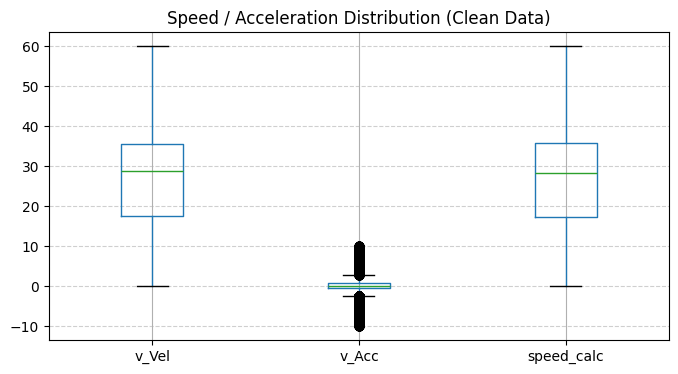

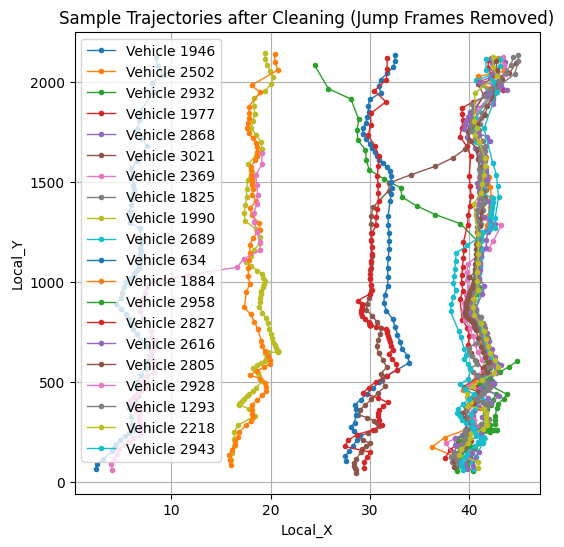

In [48]:

# ============================================
# 9. Visualization
# ============================================
print("\nPlotting data distributions...")

# Speed/acceleration boxplot
plt.figure(figsize=(8,4))
df[["v_Vel", "v_Acc", "speed_calc"]].boxplot()
plt.title("Speed / Acceleration Distribution (Clean Data)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Sample trajectories
plt.figure(figsize=(6,6))

sample_ids = df["Vehicle_ID"].drop_duplicates().sample(20, random_state=42)

for vid in sample_ids:
    sub = df[df["Vehicle_ID"] == vid]
    plt.plot(sub["Local_X"], sub["Local_Y"], marker='.', linewidth=1, label=f"Vehicle {vid}")

plt.title("Sample Trajectories after Cleaning (Jump Frames Removed)")
plt.xlabel("Local_X")
plt.ylabel("Local_Y")
plt.grid(True)
plt.legend()
plt.show()

In [49]:
# ============================================
# 10. Save final cleaned dataset
# ============================================
df.to_csv("cleaned_us101_final_clean.csv", index=False)
print("Saved cleaned_us101_final_clean.csv")
print("Preprocessing completed successfully.")

Saved cleaned_us101_final_clean.csv
Preprocessing completed successfully.
